I want to see whether a Dollar Cost Averaging strategy is worthwhile. 

To test it, I will compare these strategies on a simulated stock index : 

    1. Buy-and-Hold : Invest a single lump sum at the first available price and hold the purchased shares for the full horizon
    2. Dollar Cost Averaging (DCA) strategies : 
        a. Equal-month DCA : the total capital is allocated across equal monthly contributions
        b. Target monthly DCA with cash pool : the monthly contributions also compensate for shortfalls from previous months, so the net invested amount each month is equal to a fixed target while being subject to remaining cash
        c. Momentum-adaptive DCA : scale the monthly contribution by a factor that depends on month-over-month price movement
            i. Double the monthly contribution if the market rose since last month
            ii. Double if up, and halve the monthly contribution if the market fell since last month

Note : For every strategy, there is an investing period and a cumulation period. During the investing period, the monthly contributions are made until the available cash is exhausted. During the cumulation period, the wealth is simply left to evolve with the market. One half of the simulation will be the harvesting period, and the other half will be the cumulation period.

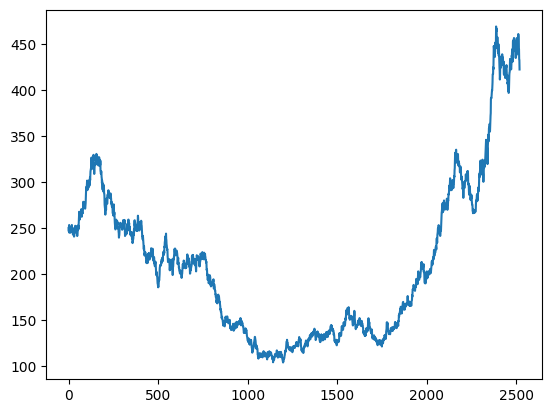

In [262]:
import numpy as np
import matplotlib.pyplot as plt

# Define a stock index (for example the S&P500)

# Use a simple stochastic model : geometric brownian motion

years = 10
days_in_year = 252
days = years * days_in_year 
dt = 1/days_in_year # a daily step is 1/252 of a year
investing_time_fraction = 0.3 # determines the percentage of time of the simulation that will be dedicated to investing, the rest will be dedicated to cumulation

mu = 0.06 # annual drift
sigma = 0.21 # annual volatility

n_indices = 10_000
index = np.zeros((days, n_indices)) 
index[0, :] = 250

for day in range(0, days-1): 
    Z = np.random.normal(size=n_indices)
    dWt = Z*np.sqrt(dt)
    index[day+1, :] = index[day, :] * np.exp((mu - 0.5*sigma**2)*dt + sigma*dWt)
        
plt.plot(index[:,0])

# 1. Buy and Hold

In [263]:
# Let's define the total amount of capital available for investment common for all strategies 

total_investment = 100_000

In [264]:
def buy_and_hold(initial_investment, market_index):
    shares_bought = initial_investment / market_index[0] # fully invest into the index
    wealth = shares_bought * market_index                # the overall wealth evolves with the market
    return wealth    

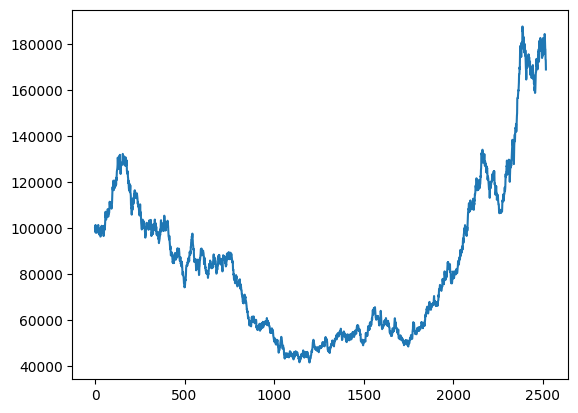

In [265]:
# For the Buy and Hold strategy, the initial investment is equal to the total investment

wealth_BH = buy_and_hold(total_investment, index)

plt.plot(wealth_BH[:, 0])

# 2.a. Dollar Cost Averaging with an identical sum is invested each month

In [266]:
# Let's assume monthly rebalancing where the same sum is invested into the portfolio 

days_in_month = days_in_year / 12
nb_rebalancing = days // days_in_month
nb_investing = days * investing_time_fraction // days_in_month  # the investing period is a fraction of the simulation horizon
nb_investing = int(nb_investing)  # ensure integer count of months
monthly_investment = total_investment / nb_investing

print(f"Portfolio is rebalanced monthly (every {days_in_month:.0f} days), by adding {monthly_investment:.2f} every month for a period of {nb_investing:.0f} months ({years*investing_time_fraction:.0f} years). The remaining {years*(1-investing_time_fraction):.0f} years is for accumulating the wealth.")

Portfolio is rebalanced monthly (every 21 days), by adding 2777.78 every month for a period of 36 months (3 years). The remaining 7 years is for accumulating the wealth.


In [267]:
# Define a dollar cost averaging strategy where the number of shares bought each month depends on the market price and the amount of monthly investment

def dollar_cost_averaging(total_investment, market_index, nb_investing):
    wealth = np.zeros((market_index.shape[0], market_index.shape[1]))
    shares_bought = 0

    nb_rebalancing = market_index.shape[0] / days_in_month
    monthly_investment = total_investment / nb_investing
    
    for entry_date in range(int(nb_rebalancing)):
        mth_start = int(days_in_month) * entry_date
        mth_end   = int(days_in_month) * (entry_date + 1)
        
        price_at_purchase = market_index[mth_start, :]  # buy at start of month
        shares_to_buy = monthly_investment / price_at_purchase if entry_date <= nb_investing  else 0 # the amount we invest each month and the price at the beginning of the month determines the number of shares we can buy
        
        shares_bought += shares_to_buy
        wealth[mth_start:mth_end, :] = shares_bought * market_index[mth_start:mth_end, :]
    
    return wealth

In [268]:
wealth_DCA = dollar_cost_averaging(total_investment, index, nb_investing)

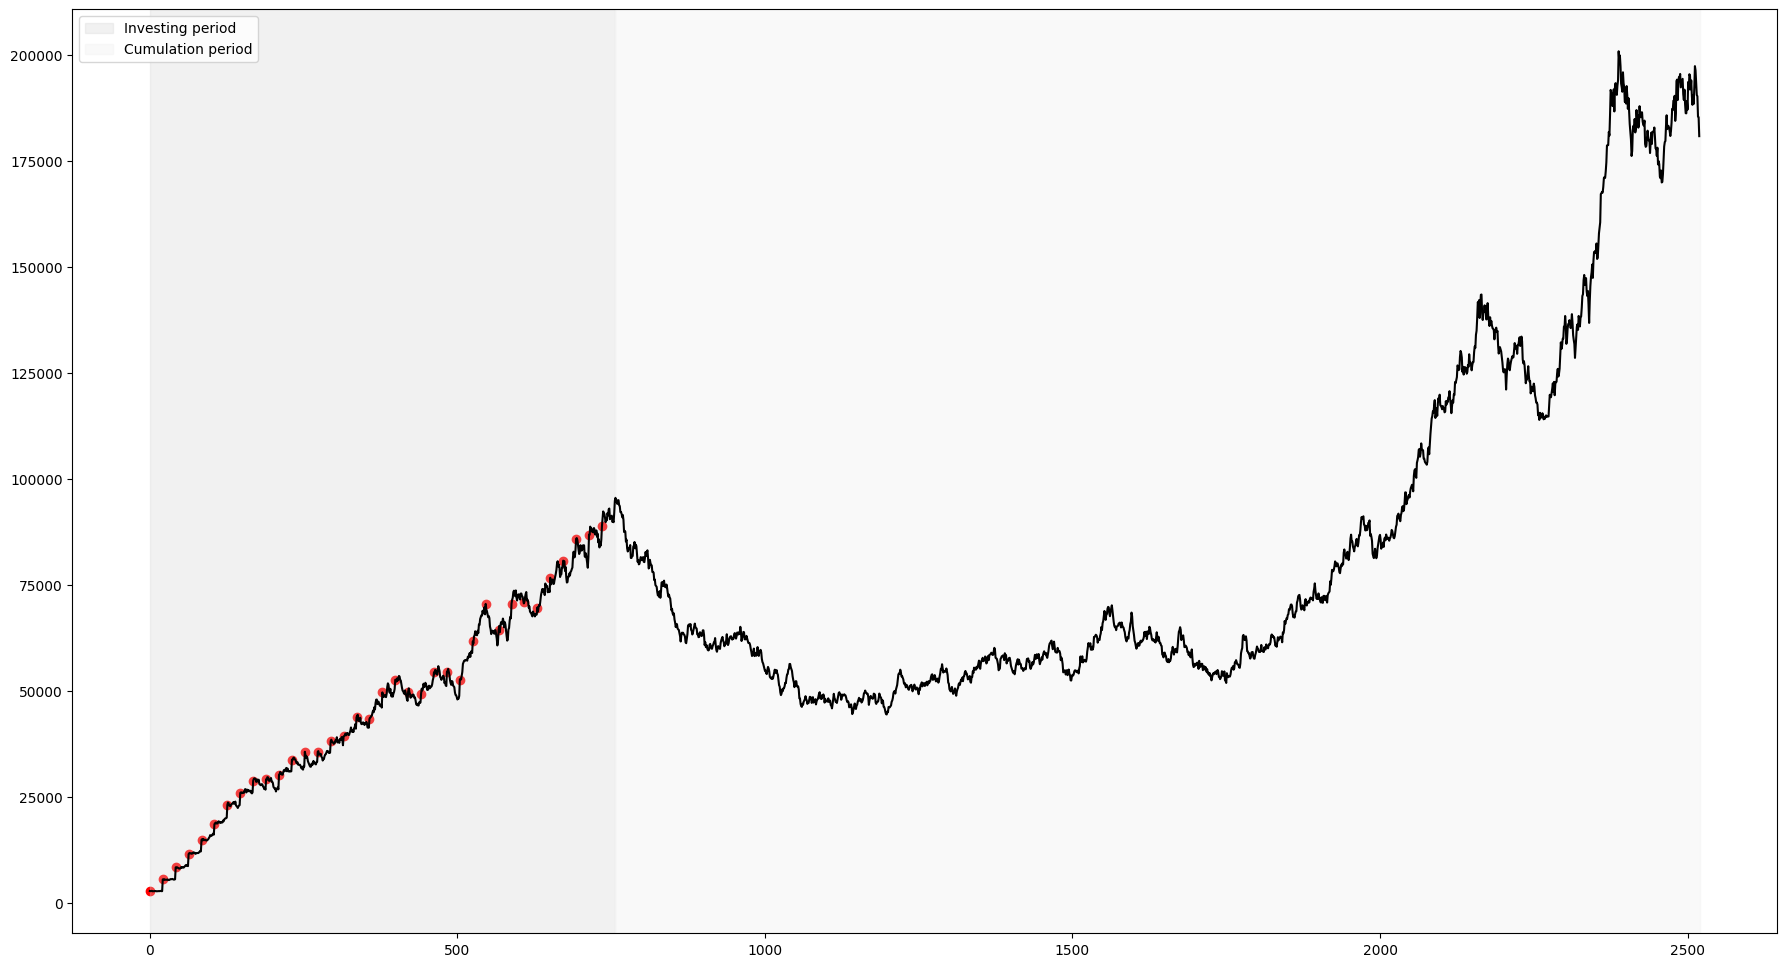

In [269]:
# Visualisation of the investing period and the cumulation period

x = range(days)[::int(days_in_month)]
y = wealth_DCA[:,0][::int(days_in_month)]

entry_points = (x, y)

plt.figure(figsize=(22,12))

# Only show the first nb_investing entry points (investing period)
investing_period = nb_investing
plt.scatter(entry_points[0][:investing_period], entry_points[1][:investing_period], color="r")

# Background shading for investing and cumulation periods
investing_end_day = investing_time_fraction * days
plt.axvspan(0, investing_end_day, color="lightgrey", alpha=0.3, label="Investing period")
plt.axvspan(investing_end_day, days, color="whitesmoke", alpha=0.6, label="Cumulation period")

plt.plot(wealth_DCA[:,0], color="black")
plt.legend()


# 2.b Dollar Cost Averaging with target monthly investment

In [270]:
# Let's modify the previous dollar cost averaging strategy by changing the amount of capital investment monthly : the monthly investment takes into account shortfall from previous month

def dollar_cost_averaging_target(total_investment, market_index, nb_investing):

    wealth = np.zeros((market_index.shape[0], market_index.shape[1]))
    remaining_cash = np.full((1, market_index.shape[1]), fill_value=total_investment)
    target_monthly_investment = np.full((1, market_index.shape[1]), fill_value=(total_investment / nb_investing))
    shares_bought = np.zeros((1, market_index.shape[1]))

    for entry_date in range(int(nb_rebalancing)):
        mth_start = int(days_in_month) * entry_date
        mth_end   = int(days_in_month) * (entry_date + 1)
        
        current_month_wealth = wealth[mth_start-1, :]
        prev_mth_target = target_monthly_investment * entry_date
        extra_cashout = np.maximum(0, prev_mth_target - current_month_wealth) # calculate the amount of extra capital to be invested based on shortfall from previous month
        
        price_at_purchase = market_index[mth_start, :]  # buy at start of month
        cash_to_invest = np.minimum(remaining_cash, target_monthly_investment + extra_cashout) # in order to make sure every strategy uses the same cash pool, limit the amount of monthly investment by the remaining cash
        shares_to_buy =  cash_to_invest / price_at_purchase if entry_date <= nb_investing  else 0
        
        shares_bought += shares_to_buy
        remaining_cash = remaining_cash - cash_to_invest
        
        wealth[mth_start:mth_end] = shares_bought * market_index[mth_start:mth_end]
    
    return wealth

In [271]:
wealth_DCA_targ = dollar_cost_averaging_target(total_investment, index, nb_investing)

# 2.c Dollar Cost Averaging with x2 if upward past returns

In [272]:
# Vectorized version

def dollar_cost_averaging_target_2up(total_investment, market_index, nb_investing):

    wealth = np.zeros((market_index.shape[0], market_index.shape[1]))
    remaining_cash = np.full((1, market_index.shape[1]), fill_value=total_investment)
    target_monthly_investment = np.full((1, market_index.shape[1]), fill_value=(total_investment / nb_investing))
    shares_bought = np.zeros((1, market_index.shape[1]))

    for entry_date in range(int(nb_rebalancing)):
        mth_start = int(days_in_month) * entry_date
        mth_end   = int(days_in_month) * (entry_date + 1)
        
        current_month_wealth = wealth[mth_start-1, :]
        prev_mth_target = target_monthly_investment * entry_date
        
        market_last_month = market_index[int(days_in_month) * (max(0, entry_date-1))]
        market_this_month = market_index[mth_start] 
        market_move = market_this_month - market_last_month 
        
        mult_coeff = np.where(market_move > 0, 2, 1)

        extra_cashout = np.maximum(0, prev_mth_target - current_month_wealth)
        
        price_at_purchase = market_index[mth_start, :]  # buy at start of month
        cash_to_invest = np.minimum(remaining_cash, target_monthly_investment*mult_coeff + extra_cashout)
        shares_to_buy =  cash_to_invest / price_at_purchase if entry_date <= nb_investing else 0
        
        shares_bought += shares_to_buy
        remaining_cash = remaining_cash - cash_to_invest
        
        wealth[mth_start:mth_end] = shares_bought * market_index[mth_start:mth_end]
    
    return wealth

wealth_DCA_2up = dollar_cost_averaging_target_2up(total_investment, index, nb_investing)

# 2.d Dollar Cost Averaging with x2 if upward past returns and x0.5 if downward past returns

In [273]:
# Vectorized version

def dollar_cost_averaging_target_2up_05down(total_investment, market_index, nb_investing):

    wealth = np.zeros((market_index.shape[0], market_index.shape[1]))
    remaining_cash = np.full((1, market_index.shape[1]), fill_value=total_investment)
    target_monthly_investment = np.full((1, market_index.shape[1]), fill_value=(total_investment / nb_investing))
    shares_bought = np.zeros((1, market_index.shape[1]))

    for entry_date in range(int(nb_rebalancing)):
        mth_start = int(days_in_month) * entry_date
        mth_end   = int(days_in_month) * (entry_date + 1)
        
        current_month_wealth = wealth[mth_start-1, :]
        prev_mth_target = target_monthly_investment * entry_date
        
        market_last_month = market_index[int(days_in_month) * (max(0, entry_date-1))]
        market_this_month = market_index[mth_start] 
        market_move = market_this_month - market_last_month 
        
        mult_coeff = np.where(market_move > 0, 2,
                     np.where(market_move < 0, 0.5, 1))
        extra_cashout = np.maximum(0, prev_mth_target - current_month_wealth)
        
        price_at_purchase = market_index[mth_start, :]  # buy at start of month
        cash_to_invest = np.minimum(remaining_cash, target_monthly_investment*mult_coeff + extra_cashout)
        shares_to_buy =  cash_to_invest / price_at_purchase if entry_date <= nb_investing  else 0
                
        shares_bought += shares_to_buy
        remaining_cash = remaining_cash - cash_to_invest
        
        wealth[mth_start:mth_end] = shares_bought * market_index[mth_start:mth_end]
    
    return wealth

wealth_DCA_2up_05down = dollar_cost_averaging_target_2up_05down(total_investment, index, nb_investing)

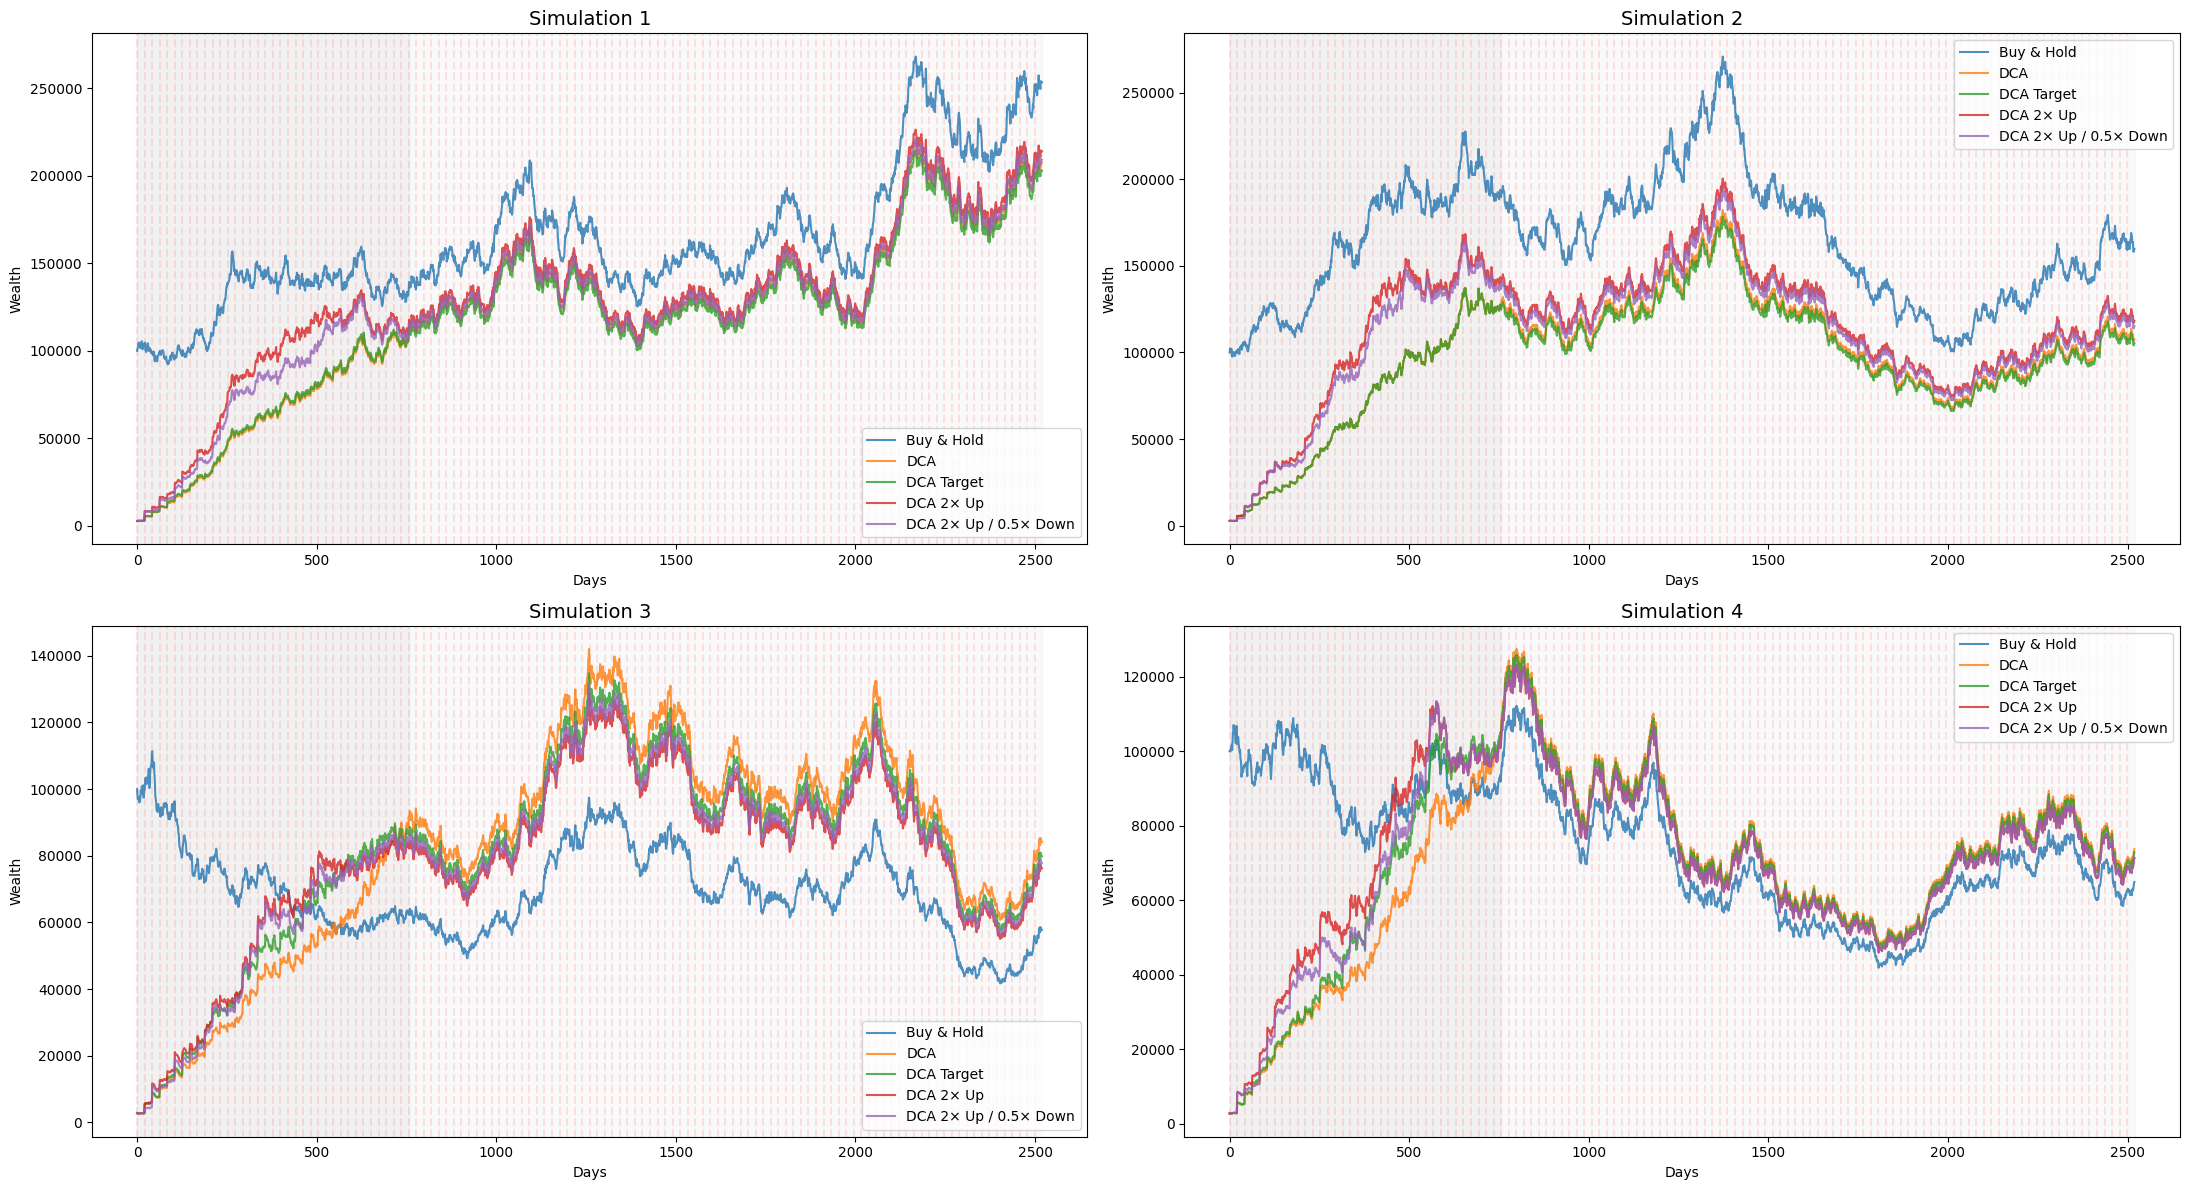

In [274]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    col = i + 1 

    ax.plot(wealth_BH[:, col], label="Buy & Hold", color="#1f77b4", alpha=0.8)
    ax.plot(wealth_DCA[:, col], label="DCA", color="#ff7f0e", alpha=0.8)
    ax.plot(wealth_DCA_targ[:, col], label="DCA Target", color="#2ca02c", alpha=0.8)
    ax.plot(wealth_DCA_2up[:, col], label="DCA 2× Up", color="#d62728", alpha=0.8)
    ax.plot(wealth_DCA_2up_05down[:, col], label="DCA 2× Up / 0.5× Down", color="#9467bd", alpha=0.8)
    
    # Background shading for investing and cumulation periods
    ax.axvspan(0, investing_end_day, color="lightgrey", alpha=0.3)
    ax.axvspan(investing_end_day, days, color="whitesmoke", alpha=0.6)

    # Plot vertical lines for entry points
    for x in entry_points[0]:
        ax.axvline(x, color='r', linestyle='--', alpha=0.1)

    ax.set_title(f"Simulation {col}", fontsize=14)
    ax.set_xlabel("Days")
    ax.set_ylabel("Wealth")
    ax.legend()

plt.tight_layout()
plt.show()


# Which strategy protects against wealth loss the most?

In [275]:
def histogram(wealth_indices):
    terminal_prices = wealth_indices[-1]
    bin_width = 0.1 * total_investment
    bins = np.arange(0, terminal_prices.max() + bin_width, bin_width)
    return terminal_prices, bins

def wealth_loss_risk(wealth_indices, threshold):
    return wealth_indices[-1][wealth_indices[-1] < threshold].size / wealth_indices[-1].size

def low_wealth_value(wealth_indices, threshold):
    low_values = wealth_indices[-1][wealth_indices[-1] < threshold]
    return low_values.mean() if low_values.size > 0 else np.nan

ref_name = "Buy & Hold"
ref_wealth = wealth_BH
strategies = {
    "DCA": wealth_DCA,
    "DCA Target": wealth_DCA_targ,
    "DCA 2× Up": wealth_DCA_2up,
    "DCA 2× Up / 0.5× Down": wealth_DCA_2up_05down,
}

colors = {
    "Buy & Hold": "#1f77b4",
    "DCA": "#ff7f0e",
    "DCA Target": "#2ca02c",
    "DCA 2× Up": "#d62728",
    "DCA 2× Up / 0.5× Down": "#9467bd"
}

ref_terminal, _ = histogram(ref_wealth)
ref_risk = wealth_loss_risk(ref_wealth, total_investment)
ref_low = low_wealth_value(ref_wealth, total_investment)


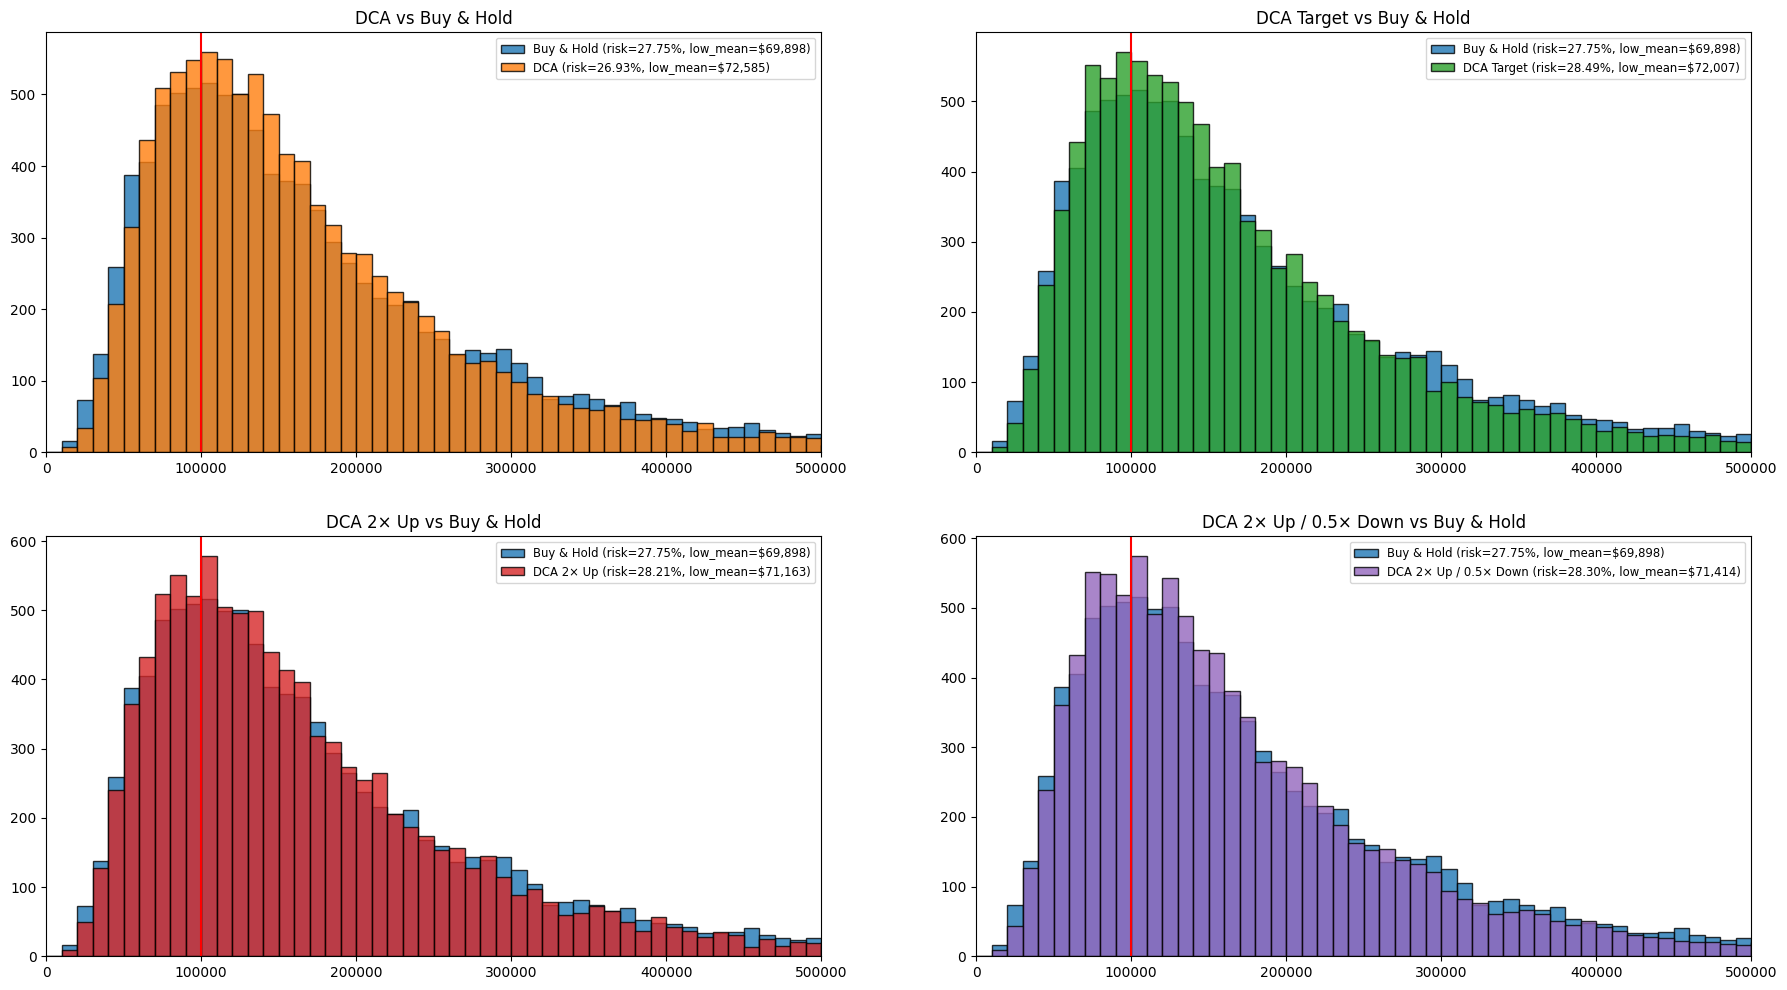

In [276]:
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
axes = axes.flatten()

for ax, (name, w) in zip(axes, strategies.items()):
    term, _ = histogram(w)
    combined_max = max(ref_terminal.max(), term.max())
    common_bin_width = 0.1 * total_investment
    common_bins = np.arange(0, combined_max + common_bin_width, common_bin_width)

    r = wealth_loss_risk(w, total_investment)
    low = low_wealth_value(w, total_investment)
    low_label = f"${low:,.0f}"

    # plot Buy & Hold
    ax.hist(ref_terminal, bins=common_bins, alpha=0.8, edgecolor="black",
            color=colors["Buy & Hold"],
            label=f"{ref_name} (risk={ref_risk:.2%}, low_mean=${ref_low:,.0f})")

    # plot strategy
    ax.hist(term, bins=common_bins, alpha=0.8, edgecolor="black",
            color=colors[name],
            label=f"{name} (risk={r:.2%}, low_mean={low_label})")

    ax.axvline(total_investment, color="red")
    ax.set_xlim(0, total_investment * 5)
    ax.set_title(f"{name} vs {ref_name}")
    ax.legend(fontsize="small")

Conclusion 

A simple DCA strategy has benefits: the risk of the terminal wealth being below the initial cash pool is lower than the rest of the strategies including Buy and Hold. The average value of the terminal portfolio wealth below the initial cash pool is higher than that of different strategies too, but this is true for all variations of the DCA strategy. Overall, a simple dollar cost averaging strategy implemented on a montlhy basis for a certain period of time (investing period) yields benefits that become visible after letting the portfolio accumulate wealth over time without rebalancing the portfolio by adding additional capital. 